In [1]:
import timm
import open_clip
import os
os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
import torch
torch.set_grad_enabled(False)
import psutil
from lavis.models.eva_vit import create_eva_vit_g
from lavis.common.registry import registry
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm
import gc
import cv2
cpu_device = torch.device('cpu')
gpu_device = torch.device('cuda')

/opt/conda/envs/eval/lib/python3.8/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/opt/conda/envs/eval/lib/python3.8/site-packages/transformers/utils/generic.py:311: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
def print_mem_stats():
    mem = psutil.virtual_memory()
    total_system_memory = mem.total / (1024 ** 2)
    used_system_memory = mem.used / (1024 ** 2)
    total_gpu_memory = torch.cuda.get_device_properties(0).total_memory / (1024 ** 2)
    reserved_gpu_memory = torch.cuda.memory_reserved(0) / (1024 ** 2)
    allocated_gpu_memory = torch.cuda.memory_allocated(0) / (1024 ** 2)
    percent_gpu_total = (allocated_gpu_memory / total_gpu_memory)*100
    percent_gpu_reserved = (reserved_gpu_memory / total_gpu_memory)*100
    percent_cpu_total = (used_system_memory / total_system_memory)*100
    print(f"mem used gpu: {allocated_gpu_memory:.2f} MB, reserved gpu: {reserved_gpu_memory:.2f}MB -> {percent_gpu_total:.2f}% of total, {percent_gpu_reserved:.2f}% reserved")
    print(f"mem used cpu: {used_system_memory:.2f} MB -> {percent_cpu_total:.2f}% of total")

print_mem_stats()

mem used gpu: 0.00 MB, reserved gpu: 0.00MB -> 0.00% of total, 0.00% reserved
mem used cpu: 4415.40 MB -> 9.16% of total


In [3]:
import pickle
# use the outputs from step 1
with open('outputs.pkl', 'rb') as f:
    outputs = pickle.load(f)

In [4]:
visual_encoder = create_eva_vit_g(512, precision='fp32').to(gpu_device)
print_mem_stats()

Position interpolate from 16x16 to 36x36
mem used gpu: 3766.48 MB, reserved gpu: 3784.00MB -> 16.75% of total, 16.82% reserved
mem used cpu: 4631.98 MB -> 9.61% of total


In [5]:
cosine_similarity = torch.nn.CosineSimilarity(dim=-1)

# calculate the global feature vector
scene_img = outputs["sceneshotcam"]
print(scene_img.shape)
scene_tensor = torch.tensor(scene_img).permute(2, 0, 1).unsqueeze(0).float().to(gpu_device)

print(scene_tensor.shape)
global_feat = visual_encoder(scene_tensor)
global_feat = global_feat.half()
global_feat = global_feat.mean(1)
global_feat = torch.nn.functional.normalize(global_feat, dim=-1)
FEAT_DIM = global_feat.shape[-1]
print_mem_stats()

(512, 512, 3)
torch.Size([1, 3, 512, 512])
mem used gpu: 3777.60 MB, reserved gpu: 4044.00MB -> 16.80% of total, 17.98% reserved
mem used cpu: 4824.11 MB -> 10.01% of total


In [6]:
import numpy as np

point_feature_cameras = ['sceneshotcam', 'apple', 'milk', 'cereal', 'bread', 'banana', 'bin', 'table', 'ur5e', 'panda']
specific_views = ['panda', 'cereal', 'milk', 'bread', 'apple', 'ur5e', 'banana', 'bin', 'table']#list(set(point_feature_cameras) - {"sceneshotcam"} - {f"genpurp__{i}" for i in range(1,6)})
feat_per_obj = []
obj_sim_per_unit_area = []
for view in tqdm(specific_views):
    # crop the image to the bounding box and run it through the visual encoder to get the feature vector for the object
    obj_img = outputs[view]
    # obj_img = cv2.resize(obj_img, (224, 224))
    # obj_img = np.array(Image.open(f"rocobench/test_images/ground truths/{view}.png").convert("RGB").resize((512, 512)))
    img_roi = torch.tensor(obj_img).permute(2, 0, 1).unsqueeze(0).float().to(gpu_device)
    roifeat = visual_encoder(img_roi)
    roifeat = roifeat.half().cuda()
    roifeat = roifeat.mean(1)
    roifeat = torch.nn.functional.normalize(roifeat, dim=-1)
    feat_per_obj.append(roifeat)

    # calculate the cosine similarity between the global feature vector and the feature vector for the object and save that as well
    _sim = cosine_similarity(global_feat, roifeat)
    obj_sim_per_unit_area.append(_sim)

    torch.cuda.empty_cache()

visual_encoder = None
del visual_encoder
gc.collect()
torch.cuda.empty_cache()

print_mem_stats()

100%|██████████| 9/9 [00:03<00:00,  2.26it/s]


mem used gpu: 14.16 MB, reserved gpu: 42.00MB -> 0.06% of total, 0.19% reserved
mem used cpu: 4796.36 MB -> 9.95% of total


In [7]:
print("global feature shape:", global_feat.shape)

global feature shape: torch.Size([1, 1408])


In [7]:
scores = torch.cat(obj_sim_per_unit_area).to(gpu_device)
feat_per_obj = torch.cat(feat_per_obj, dim=0).to(gpu_device)
# norm_feat_per_obj = torch.nn.functional.normalize(feat_per_obj, p=2, dim=1)

# get the cosine simixlarity between the features of each object. This will be a square matrix where the (i, j)th entry is the cosine similarity between the ith and jth objects
mask_sim_mat = torch.nn.functional.cosine_similarity(
    feat_per_obj[:, :, None], feat_per_obj.t()[None, :, :]
)
mask_sim_mat_untouched = mask_sim_mat.clone()
print(mask_sim_mat)
mask_sim_mat.fill_diagonal_(0.0) # set the diagonal to 0 because we don't want to consider the similarity between the same object
mask_sim_mat = mask_sim_mat.mean(1)  # avg sim of each mask with each other mask
print(mask_sim_mat)
softmax_scores = scores.cuda() - mask_sim_mat # subtracting the object-object relevance (which can be thought of as the relevance of the object in context of the other objects) object-scene similarity (which is kind of like global relevance) gives how much more or less important that object is than all the other objects
softmax_scores = torch.nn.functional.softmax(softmax_scores, dim=0) # apply softmax to get the final scores

print(specific_views)
print(softmax_scores)

print_mem_stats()

tensor([[1.0000, 0.9512, 0.9619, 0.9829, 0.9624, 0.9771, 0.9639, 0.9722, 0.9604],
        [0.9512, 1.0000, 0.9458, 0.9629, 0.9785, 0.9424, 0.9678, 0.9717, 0.9595],
        [0.9619, 0.9458, 1.0000, 0.9824, 0.9785, 0.9771, 0.9907, 0.9819, 0.9922],
        [0.9829, 0.9629, 0.9824, 1.0000, 0.9844, 0.9814, 0.9844, 0.9868, 0.9819],
        [0.9624, 0.9785, 0.9785, 0.9844, 1.0010, 0.9692, 0.9897, 0.9902, 0.9878],
        [0.9771, 0.9424, 0.9771, 0.9814, 0.9692, 1.0000, 0.9756, 0.9751, 0.9736],
        [0.9639, 0.9678, 0.9907, 0.9844, 0.9897, 0.9756, 1.0000, 0.9907, 0.9951],
        [0.9722, 0.9717, 0.9819, 0.9868, 0.9902, 0.9751, 0.9907, 0.9995, 0.9927],
        [0.9604, 0.9595, 0.9922, 0.9819, 0.9878, 0.9736, 0.9951, 0.9927, 1.0000]],
       device='cuda:0', dtype=torch.float16)
tensor([0.8589, 0.8535, 0.8677, 0.8721, 0.8711, 0.8633, 0.8730, 0.8735, 0.8716],
       device='cuda:0', dtype=torch.float16)
['panda', 'cereal', 'milk', 'bread', 'apple', 'ur5e', 'banana', 'bin', 'table']
tensor([0.

In [9]:
torch.save(mask_sim_mat_untouched, "figure_data/blip_noneva_rendfet_sim_square.pt")

In [9]:
print(feat_per_obj.shape)

torch.Size([9])


In [8]:
pixelwise_features = torch.zeros(outputs['xyz_pts'].shape[0], FEAT_DIM, dtype=torch.half)#global_feat.repeat((xyz_pts.shape[0], 1))
print(pixelwise_features.shape)#torch.zeros(xyz_pts.shape[0], FEAT_DIM, dtype=torch.half)
print_mem_stats()

torch.Size([2615298, 1408])
mem used gpu: 14.16 MB, reserved gpu: 42.00MB -> 0.06% of total, 0.19% reserved
mem used cpu: 11799.45 MB -> 24.49% of total


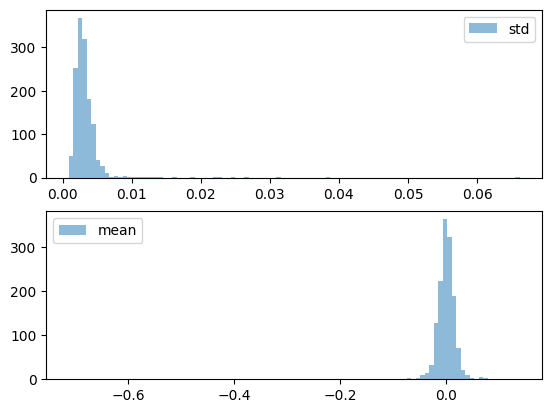

In [15]:
all_feats = torch.cat([feat_per_obj, global_feat],dim=0)
stds = torch.std(all_feats, dim=0)
means = torch.mean(all_feats, dim=0)

import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2)
axs[0].hist(stds.cpu().numpy(), bins=100, alpha=0.5, label="std")
axs[0].legend()
axs[1].hist(means.cpu().numpy(), bins=100, alpha=0.5, label="mean")
axs[1].legend()
plt.show()

In [9]:
pixelwise_features = pixelwise_features.to(gpu_device)
for objidx in range(len(specific_views)):
    _weighted_feat = (
        softmax_scores[objidx] * global_feat + (1 - softmax_scores[objidx]) * feat_per_obj[objidx]
    )
    _weighted_feat = torch.nn.functional.normalize(_weighted_feat, dim=-1)
    pixelwise_features[outputs['segmentation_pts'][specific_views[objidx]], :] = _weighted_feat
    # second normalization is unnecessary because all pixels in each object receive the same feature, and each point is only interacted with once.
    # instead, we will normalize the features after voxel aggregation

print_mem_stats()

mem used gpu: 7037.67 MB, reserved gpu: 7082.00MB -> 31.29% of total, 31.49% reserved
mem used cpu: 4768.09 MB -> 9.89% of total


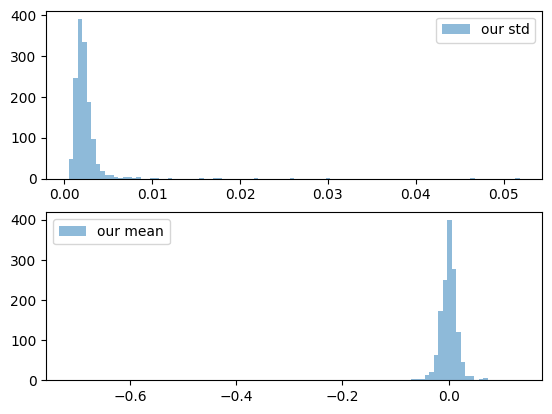

In [10]:
our_std = torch.std(pixelwise_features, dim=0)
our_mean = torch.mean(pixelwise_features, dim=0)
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2)
axs[0].hist(our_std.cpu().numpy(), bins=100, alpha=0.5, label="our std")
axs[0].legend()
axs[1].hist(our_mean.cpu().numpy(), bins=100, alpha=0.5, label="our mean")
axs[1].legend()
plt.show()

In [11]:
# we have to save the pixelwise features as a tensor so that we can do the voxel grid sampling
# unfortunately, that doesn't work with the version of pytorch that we use this notebook
# WIP
torch.save(pixelwise_features.cpu(), "blip_noneva_pixelwise_rendfet_features.pt")